In [12]:
#!conda install pytorch
#!conda install Pillow
#!conda install scikit-image
#conda install -c conda-forge opencv
#conda install -c conda-forge keras
#conda install -c conda-forge tensorflow

In [3]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder
import cv2
import PIL


Setting up GPU for caluculations

In [ ]:
#conda create --name tf_gpu tensorflow-gpu 

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


Converting the JSON file to a Pandas dataframe but dropping image 4215425.jpg as this was corrupted

In [5]:
# Load JSON: json_data
with open("dataset.json") as json_file:
    json_data = json.load(json_file)

# Create a list to hold the labels
labels = []

# Extract the image IDs and price categories
for item in json_data:
    try:
        if "price_category" in item and "more_details" in item and "full_images" in item["more_details"]:
            price_category = item["price_category"]["label"]
            images = item["more_details"]["full_images"]
            for image in images:
                image_id = image["image_id"]
                labels.append({"image_id": image_id, "price_category": price_category})
    except TypeError:
        continue

# Convert the labels list to a Pandas DataFrame
labels = pd.DataFrame(labels, index=None)

# Drop the row with image ID '4215425.jpg'
labels = labels.drop(labels.loc[labels['image_id'] == '4215425.jpg'].index)


This code makes a validation file 

In [4]:
import os
import shutil

# Set up directories
train_dir = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train'
test_dir = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test'
classes = ['Moderate spend', 'On a budget', 'Spare no expense', 'Special occasion']

# Create test directory if it doesn't exist
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Move images from each class to test directory
for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    test_class_dir = os.path.join(test_dir, cls)
    if not os.path.exists(test_class_dir):
        os.mkdir(test_class_dir)
    files = os.listdir(class_dir)
    for i in range(2000):
        src = os.path.join(class_dir, files[i])
        dst = os.path.join(test_class_dir, files[i])
        shutil.move(src, dst)


Setting up the paths to the files. 

In [5]:
train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

Changing the images so Inception V3 can read them 

In [6]:
train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=train_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10)
test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)
valid_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path,target_size=(256,256),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


How Inception V3 sees images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

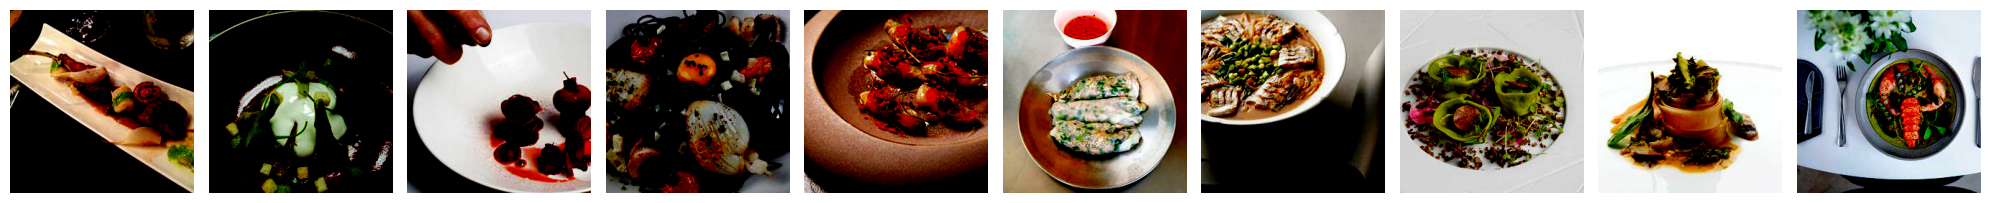

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [18]:
imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

Models with no clean data

Using InceptionV3 model

With clean data

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the InceptionV3 layers
for layer in inceptionv3.layers:
    layer.trainable = False

input_shape=(256,256,3)
# Build a classifier on top of the InceptionV3 model with additional layers
model = Sequential([ 
    inceptionv3, 
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'), 
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling2D(),
    Dense(units=4, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_batch = train_datagen.flow_from_directory(train_path,
                                                target_size=(256,256),
                                                batch_size=16,
                                                class_mode='categorical')
test_batch = test_datagen.flow_from_directory(test_path,
                                              target_size=(256,256),
                                              batch_size=16,
                                              class_mode='categorical')

# Train the model and save the history
history = model.fit(train_batch, epochs=100, validation_data=test_batch)

# Plot the loss and validation loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\multiprocessing\util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\multiprocessing\pool.py", line 687, in _terminate_pool
    change_notifier.put(None)
  File "c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\multiprocessing\queues.py", line 374, in put
    self._writer.send_bytes(obj)
  File "c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\multiprocessing\connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
KeyboardInterrupt: 


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Epoch 1/100
 401/1108 [=========>....................] - ETA: 2:03 - loss: 1.3749 - accuracy: 0.3137

KeyboardInterrupt: 

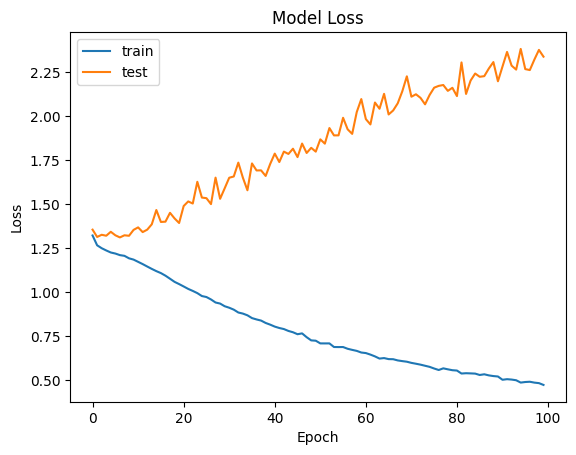

In [15]:
# Plot the loss and validation loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

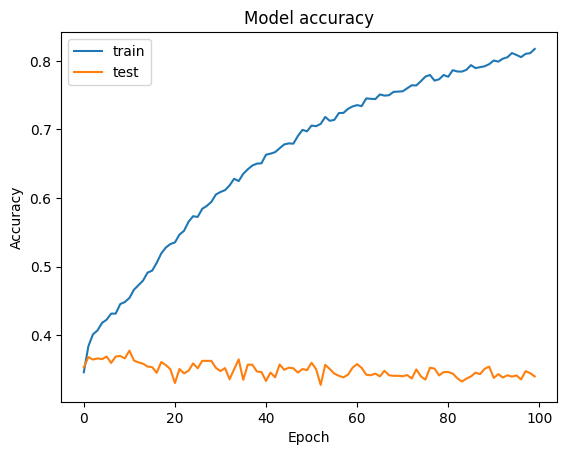

In [17]:
# Plot the accuracy and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

61/61 [==============================] - 4s 36ms/step - loss: 2.7043 - accuracy: 0.2691
Test loss: 2.704274892807007, Test accuracy: 0.2691029906272888


Exporting the model. 

In [10]:
# Save Weight model
model.save_weights("model1.h5")